In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
from scipy.stats import gaussian_kde

import seaborn as sns
import math
import numpy as np
import pybaseball as pyb

import stat

pd.options.display.max_columns = None

In [14]:
strike_zone_width = 1.66 # 0.83 + 0.83
strike_zone_height = 2.34 # 3.72 - 1.38
left_of_zone = -strike_zone_width / 2
right_of_zone = strike_zone_width / 2
bottom_of_zone = 1.38
top_of_zone = 3.72
ball_width = (9/np.pi)/12

font_properties = {'family': 'DejaVu Sans', 'size': 12}
font_properties_titles = {'family': 'DejaVu Sans', 'size': 12}
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

sns.set_theme(style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.5, color_codes=True, rc=None)
mpl.rcParams['figure.dpi'] = 300

In [17]:
statcast_data = pyb.statcast('2024-03-01', '2025-11-01')
statcast_data = statcast_data[~statcast_data['pitch_type'].isna()].sort_values(by='game_date').reset_index(drop=True).copy() ## gets rid of the null pitches
statcast_data = statcast_data[statcast_data['game_type'] == 'R'].reset_index(drop=True).copy()

# statcast_data['plate_x'] = statcast_data['plate_x']*-1

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/478 [00:00<?, ?it/s]/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/478 [00:10<1:20:24, 10.11s/it]/Users/buttz/miniforge3/lib/python3.10/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime

In [73]:
pitch_type_dict = {'CH': 'Changeup', 
                   'CU': 'Curveball',
                   'FC': 'Cutter',
                   'EP': 'Eephus',
                   'FO': 'Forkball',
                   'FF': 'Four-Seam',
                   'KN': 'Knuckleball',
                   'KC': 'Knuckle-curve',
                   'SC': 'Screwball',
                   'SI': 'Sinker',
                   'SL': 'Slider',
                   'SV': 'Slurve',
                   'FS': 'Splitter',
                   'ST': 'Sweeper'}

In [74]:
def plot_pitcher_pitch_heatmap(df: pd.DataFrame, pitcher_name: str, pitch_name: str, ax: plt.axes):
    """
    Plots KDE heatmaps of pitch locations for all pitch types of a single pitcher,
    with a true MLB strike zone and handling missing pitch data.
    """
    df = df[df['player_name'] == pitcher_name].reset_index(drop=True).copy()

    pitch_count = df[(df['pitch_type'] == pitch_name)].shape[0]
    pitch_usage = round((pitch_count / (df).shape[0]) * 100, 1)
    kde = sns.kdeplot(data=df[(df['pitch_type'] == pitch_name)], x='plate_x', y='plate_z', cmap='coolwarm', fill=True, ax=ax)

    ## strike zone code
    outer_zone_width = strike_zone_width + 0.48
    outer_zone_height = strike_zone_height + 0.48
    bottom_of_outer_zone = bottom_of_zone - 0.24
    left_of_outer_zone = left_of_zone - 0.24

    strike_zone = patches.Rectangle((left_of_zone, bottom_of_zone), strike_zone_width, strike_zone_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(strike_zone)
    
    # outer_zone = patches.Rectangle((left_of_outer_zone, bottom_of_outer_zone), outer_zone_width, outer_zone_height, linewidth=1, edgecolor='black', alpha=0.8, facecolor='none')
    # ax.add_patch(outer_zone)

    # for i in range(1, 3):  
    #     x = left_of_zone + (i * strike_zone_width / 3)
    #     ax.plot([x, x], [bottom_of_zone, bottom_of_zone + strike_zone_height], color='gray', linestyle='-')
    # for i in range(1, 3):  
    #     y = bottom_of_zone + (i * strike_zone_height / 3)
    #     ax.plot([left_of_zone, left_of_zone + strike_zone_width], [y, y], color='gray', linestyle='-')

    ax.grid()
    ax.legend().remove()
    ax.set_xticks(range(-2, 3, 1))
    ax.set_xticklabels(range(-2, 3, 1), fontdict=font_properties)
    ax.set_yticks(range(0, 6, 1))
    ax.set_yticklabels(range(0, 6, 1), fontdict=font_properties)
    x_min, x_max = df['plate_x'].min(), df['plate_x'].max()
    y_min, y_max = df['plate_z'].min(), df['plate_z'].max()
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_axis_off()
    ax.set_xlabel('Horiontal Location (ft.)', fontdict=font_properties_axes)
    ax.set_ylabel('Vertical Location (ft.)', fontdict=font_properties_axes)
    pitch_name_cleaned = " ".join(pitcher_name.split(', ')[::-1])
    ax.set_title(f"{pitch_name_cleaned}'s {pitch_type_dict[pitch_name]}\n", fontdict=font_properties_titles, loc='left', pad=6)
    ax.text(0.0, 1.02, f"{pitch_count} Pitches ({pitch_usage}%)", transform=ax.transAxes, ha='left', va='bottom', fontsize=10, color='gray')
    ax.set_aspect('equal', adjustable='box')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

    cbar = plt.colorbar(kde.collections[0], ax=ax, pad=0.02)
    # cbar.set_label("Estimated pitches", fontsize=12)
    ticks = cbar.get_ticks()
    cbar.set_ticks(ticks)
    cbar.set_ticklabels((ticks * pitch_count).astype(int))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


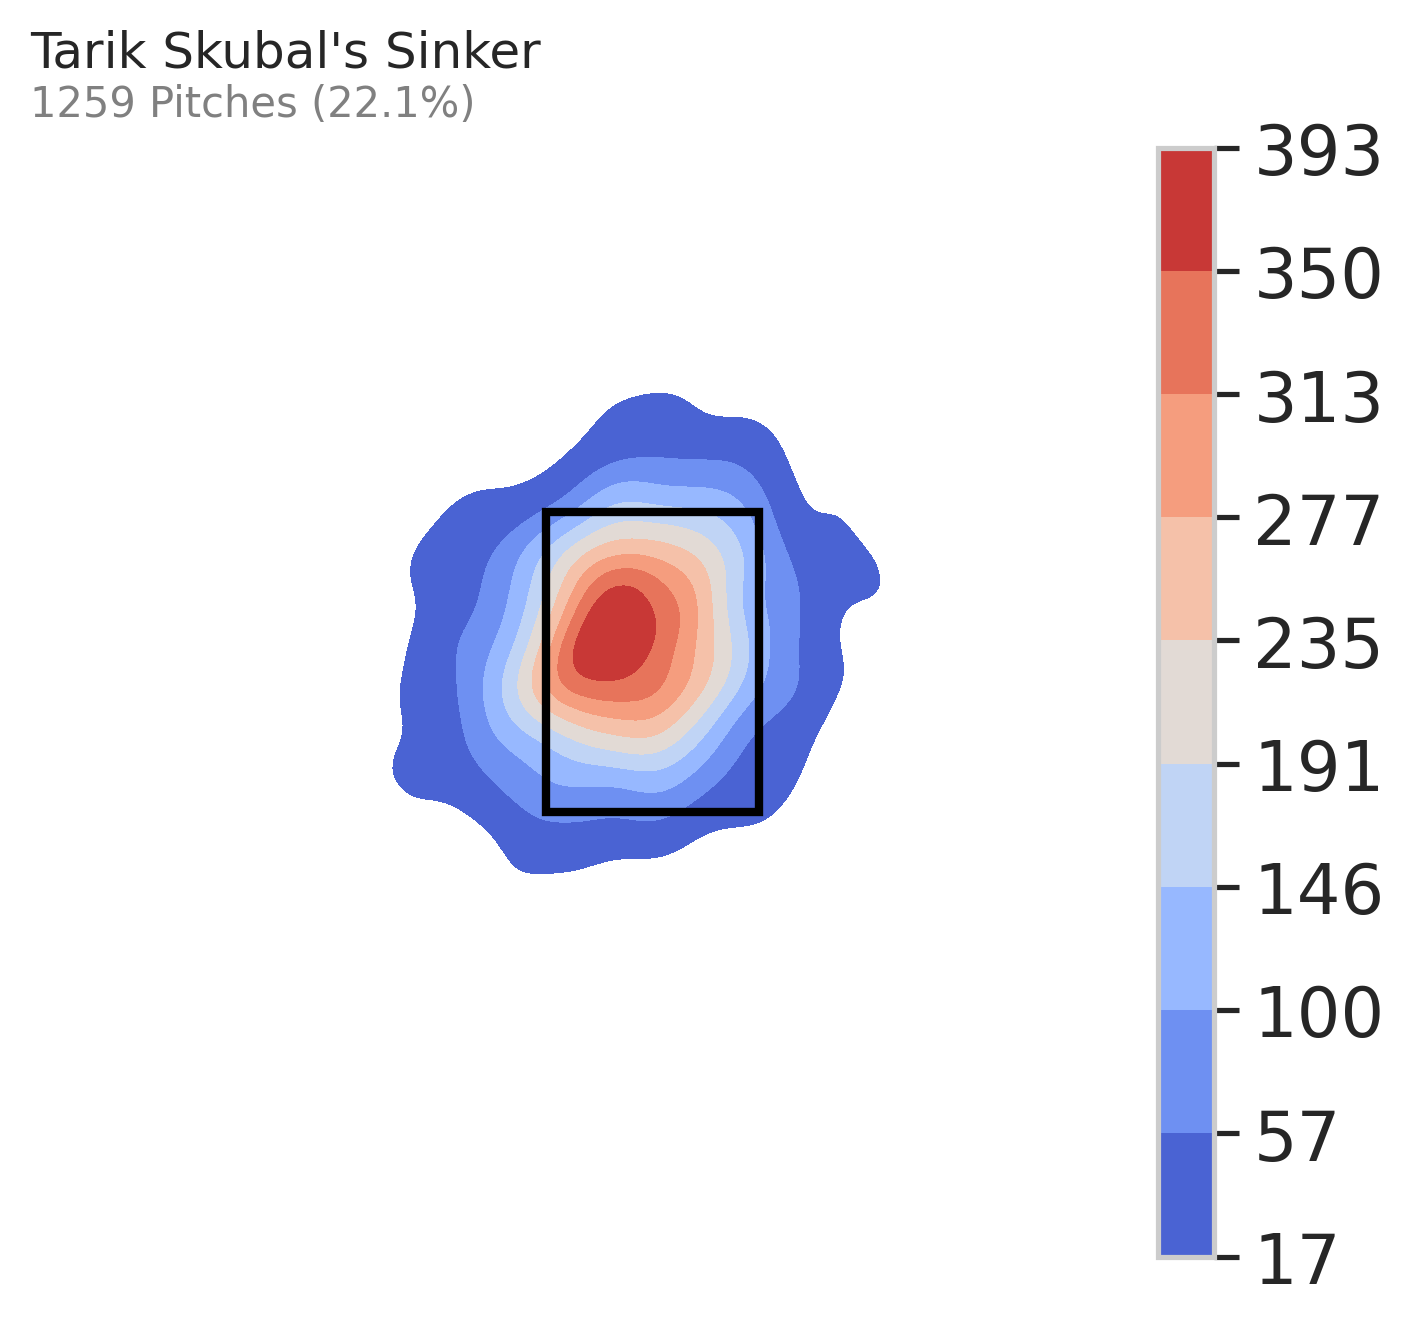

In [105]:
plot_pitcher_pitch_heatmap(statcast_data, 'Skubal, Tarik', 'SI', plt.subplots()[1])

In [ ]:
df = pd.read_csv("../../Files/pitch_class_trackman_games.csv").iloc[:, 1:].copy()

pitch_colors = {'Four-Seam': 'blueviolet',
                'Sinker': 'magenta', 
                'Cutter': 'crimson', 
                'Changeup': 'cyan', 
                'Splitter': 'teal', 
                'Slider': 'lawngreen', 
                'Curveball': 'yellow',
                # 'Sweeper': 'orange',
                # 'Knuckleball': '#1BB999',
                # 'Unknown': 'lightgrey'
                } 

valid_pitches = {k for k in pitch_colors if k != 'Unknown'}
df['PlateLocSide'] = df['PlateLocSide']*-1

In [29]:
df[df["Pitcher"] == "Weber, Chapman"]['predTaggedPitch'].value_counts(normalize=True)

predTaggedPitch
Four-Seam    0.891026
Slider       0.086538
Curveball    0.019231
Cutter       0.003205
Name: proportion, dtype: float64

In [21]:
df[df["Pitcher"] == "Weber, Chapman"].groupby('predTaggedPitch').agg({'RelSpeed': 'max', 'InducedVertBreak': 'max'})

,RelSpeed,InducedVertBreak
predTaggedPitch,,
Curveball,78.87590,-2.31508
Cutter,85.21744,7.38244
Four-Seam,92.08434,30.42706
Slider,81.78370,3.79091


In [13]:
pitcher_name = "Weber, Chapman"
pitcher_data = df[df["Pitcher"] == pitcher_name]

# Then you can run your for loop
for i, pitch in enumerate(pitcher_data['TaggedPitchType'].unique().tolist()):
    print(pitch)

Four-Seam
Slider
Cutter
Changeup
